In [1]:
# Adapting the 1DHT model from Hornum et al. (2020) from MATLAB to Python

In [140]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
from line_profiler import LineProfiler

In [144]:
#      Constants and general model setup
toyr =60*60*24*365     # to year from s

            # Thermal properties of water and ice (from Williams and Smith, 1989) %%%
            
p_w = 1000             # density [kg/m3]
cp_w = 4180            # specific heat capacity [J/(kg*K)]
k_w = 0.56*toyr # thermal conductivity [(J/yr)/(m K)]

p_ice = 917
cp_ice = 2100
k_ice = 2.24*toyr
L=333.6*1000           # Latent heat of fusion [J/kg]

#Julie paper

#silicate rock
p_rock = 2430
cp_rock = 2000
k_rock = 2 * toyr

#hydrated salt — not using this bc salt is being represented thru SFC Hydrohalite Schofield et al. 2014
p_salt = 2200
cp_salt = 920
k_salt = 0.6 * toyr

#p_boulder = (0.56*p_hyd)+(0.25*p_rock)+(0.19*p_salt)
#cp_boulder = (0.56*cp_hyd)+(0.25*cp_rock)+(0.19*cp_salt)
#k_boulder = (0.56*k_hyd)+(0.25*k_rock)+(0.19*k_salt)


            ## Porosity and thermal properties of CERES materials ##
            
n_Sc=1                 # Porosity scenario is chosen here: 1=minimum n, 2=intermediate n, 3=maximum n
nLob=[0.33, 0.45, 0.55, 0.66]    ## [min interm. max] Lobate (thermal model; 6B) ##
nIce = [0, 0.2, 0.4] # Lee et al. 2005


                    ### Material 1 - Lobate
#matrix material: clay (silicate ONLY)
nL = nLob[n_Sc]   
nI = nIce[n_Sc]
p_soilL = p_rock       ## DENSITY (thermal model; 2B)             
cp_soilL = cp_rock       ## HEAT CAPACITY; GRAB FROM JULIE'S DATABASE (this is going to be tricky with temperature dependence)    
k_soilL = k_rock   ## THERMAL CONDUCTIVITY; GRAB FROM JULIE'S DATABASE (40% ice, 25% hydrates)       
aQ=k_soilL/(p_soilL*cp_soilL) #THERMAL DIFFUSIVITY [m^2/yr]


            ### Model parameters ###
tstep=0.05         # time step [yr] this is the minimum time step with our material properties
ts_1yr=1/tstep     # number of time steps in a year; 20
dz=2               # cell size [m]
grid_depth=600     ## grid depth, GRID SPANS 600m (depth of lobate flow) (domain constraints; 5B)
z=np.arange(0,grid_depth+dz,dz) # cell nodes, 0,2,4,6 M ETC.
nocell=len(z)    # number of cells
#print(nocell)

In [145]:
 ### Temperature ###
Kv= -273.15              # set to -273.15 if in Kelvin. 0 if in C
T_gradient=0.00273    ## Thermal gradient [K/m] (Raymond et al. 2020) (thermal model; 7B)
T_0=273           # Initial surface temperature - NOT USED if temperature reconstruction is defined
T_end=350 # Initial temperature at bottom of grid - NOT USED in for loop (estimate from Bowling)
T_ini=np.zeros(nocell) # Initial temperature distribution, gives every cell node a temperature
for i in range(nocell):
    #if 0 <= i < 2:
    #    T_ini[i] = 150.00
    #elif 2 <= i < (nocell-1)/2:
    #    T_ini[i] = T_ini[i-1] + 0.821 #K/m
    #elif i == (nocell-1)/2:
    #    T_ini[i] = 273.15
    #elif i > (nocell-1)/2:
    #    T_ini[i] = T_ini[i-1] - 0.821
    #elif i == grid_depth-1:
    #    T_ini[i] = 150.00
    #else:
    #    T_ini_1[i] = 300.00
    T_ini[i] = 273.15

#T_ini = [round(item, 3) for item in T_ini_1] #rounding all floats to the nearest hundredth to match with interpolated SFC
print(T_ini)

[273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.1

In [146]:
# Ceres temperature reconstruction (just a .txt file) with 100k rows each with a temp of 150 K
# Load the data from the text file
TCurve_data = pd.read_csv('cerestempcurve_rampeddown.csv', header=None)

T_ann10 = TCurve_data[1] #temperatures, dep variable
tt_yr = TCurve_data[0] #years, indep variable

ttt = np.arange(0, 100000+tstep, tstep) #do this for maximum runtime, can filter down later
interp_function = interp1d(tt_yr, T_ann10, kind='linear', fill_value='extrapolate')

T_ann10q = interp_function(ttt) #interpolating the surface temperature so there is one for every time step
#print(T_ann10q)

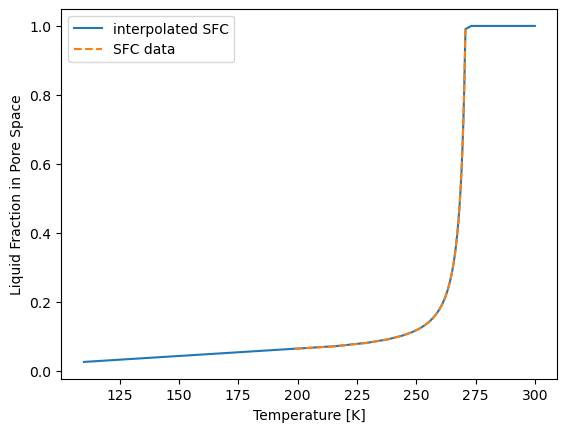

In [147]:
# reading in SFC, creating interpolated pore water fractions from input temp array and SFC

filename = ['Mg/SL_2wt_Mg.txt',	'Ca/SL_2wt_Ca.txt', 'NaCl/Sl_ph1wtnacl.txt', 'Mg/Sl_ph1wtmgper.txt']
n = 1
SFC_data = pd.read_table('/Users/alexiakubas/Desktop/Ceres/1DHT_clone/-1DHT-model-code/SFCs/resmoothedsfcs/' + filename[n],\
                         header=None, delimiter='\t')
fw = SFC_data[1] #liquid fraction in the pore space, Sl = 1- Si, dep variable
temp = SFC_data[0] #degrees Kelvin

interp_temps = np.arange(110, 300, 0.001)
interp_fw = interp1d(temp, fw, kind='linear', fill_value='extrapolate')
SFC_fw = interp_fw(interp_temps)

for i in range(len(SFC_fw)):
    if n==0: #2wt Mg
        m = 0.002397578545 # K^-1
        if SFC_fw[i] <= 0:
            SFC_fw[i] = 0
        if i >= 159890 and interp_temps[i] < 273.15: # depends on SFC
            SFC_fw[i] = m*(interp_temps[i]-273.15)+1
        if interp_temps[i] >= 273.15:
            SFC_fw[i] = 1
    elif n==1: #2wt Ca
        m = 0.003821167165
        if SFC_fw[i] <= 0:
            SFC_fw[i] = 0
        if i >= 160729 and interp_temps[i] < 273.15: # depends on SFC
            SFC_fw[i] = m*(interp_temps[i]-273.15)+1
        if interp_temps[i] >= 273.15:
            SFC_fw[i] = 1
    elif n==2: #1wt NaCl
        m = 0.1410182201
        if SFC_fw[i] <= 0:
            SFC_fw[i] = 0
        if i >= 161934 and interp_temps[i] < 273.15: # depends on SFC
            SFC_fw[i] = m*(interp_temps[i]-273.15)+1
        if interp_temps[i] >= 273.15:
            SFC_fw[i] = 1
    elif n==3: #1wt Mgper
        m = 0.1440317444
        if SFC_fw[i] <= 0:
            SFC_fw[i] = 0
        if i >= 161958 and interp_temps[i] < 273.15: # depends on SFC
            SFC_fw[i] = m*(interp_temps[i]-273.15)+1
        if interp_temps[i] >= 273.15:
            SFC_fw[i] = 1

plt.plot(interp_temps, SFC_fw, label='interpolated SFC')
plt.plot(temp, fw, label='SFC data', linestyle='dashed')
plt.xlabel('Temperature [K]')
plt.ylabel('Liquid Fraction in Pore Space')

#plt.ylim(0.9,1.1)
#plt.xlim(272.2,273.2)
plt.legend()

In [148]:
# this block of code is to figure out how to handle the gap between the data and the melting point for each SFC
np.where(np.isclose(interp_temps, 270.7296, atol=1e-6))[0]
#interp_temps[160727:160733]
#print(interp_temps[160729], SFC_fw[160729])

array([160727, 160728, 160729, 160730, 160731, 160732])

Text(0, 0.5, 'Change in Liquid Fraction in Pore Space')

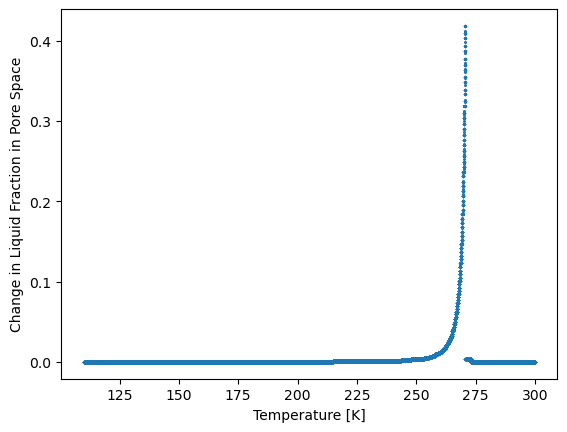

In [149]:
dfw_SFC = np.zeros(len(SFC_fw))

for i in range(len(SFC_fw)):
    if i != len(SFC_fw)-1:
        dfw_SFC[i] = (SFC_fw[i+1]-SFC_fw[i])/(interp_temps[i+1]-interp_temps[i])
    else: 
        dfw_SFC[i] = 0

plt.scatter(interp_temps, dfw_SFC, s=1.5)
plt.xlabel('Temperature [K]')
plt.ylabel('Change in Liquid Fraction in Pore Space')
#plt.ylim(-0.1,1.1)
#plt.xlim(268,270)

In [150]:
def get_fw(temp):
    if temp < interp_temps[0] or temp > interp_temps[-1]:
        raise ValueError("Input temperature is outside the valid range.")
    #if 272.150 <= temp < 272.159:
    #    f_w_value = 0.99555579 #trying to mitigate the jump by manually setting it to median value
    #elif temp >= 272.159:
    #    f_w_value = 1
    else:
        indices = np.where(np.isclose(interp_temps, temp, atol=1e-6))[0]
        if len(indices) == 0:
            raise ValueError("Input temperature not found in interp_temps.")
        index = indices[2] #this is usally the best match
        f_w_value = SFC_fw[index]
    return f_w_value

def get_dfw(temp):
    if temp < interp_temps[0] or temp > interp_temps[-1]:
        raise ValueError("Input temperature is outside the valid range.")
    #if 272.157 < temp <= 272.159:
    #    dfw_value = 0.98512213
    #elif temp > 272.159:
    #    dfw_value = 0
    else:
        indices = np.where(np.isclose(interp_temps, temp, atol=1e-6))[0]
        if len(indices) == 0:
            raise ValueError("Input temperature not found in interp_temps.")
        index = indices[2]
        dfw_value = dfw_SFC[index]
    return dfw_value

In [151]:
# reading in differential SFC, creating interpolated pore water fractions from input temp array and SFC

#dfw_data = pd.read_table('/Users/alexiakubas/Desktop/Ceres/1DHT_clone/-1DHT-model-code/SFCs/resmoothedsfcs/Mg/dSi_2wt_Mg.txt', header=None, delimiter='\t')
#dfw4 = -1*dfw_data[1] #liquid fraction in the pore space, Sl = 1- Si, dep variable
#temp5 = -1*dfw_data[0] + 273.15 #degrees Kelvin, indep variable

#interp_temps = np.arange(110, 300, 0.001)
#interp_dfw = interp1d(temp5, dfw4, kind='linear', fill_value='extrapolate')
#dfw_SFC = interp_dfw(interp_temps)

#plt.plot(interp_temps, dfw_SFC)
#plt.xlabel('Temperature [K]')
#plt.ylabel('Change in Liquid Fraction in Pore Space')
#plt.ylim(-0.1,1.1)
#plt.xlim(200,205)

In [163]:
### Assigning material IDs to the different model grids and creating empty vectors and matrices. ###

# 1=Lobate 2=Boulders 3=Ice
onegrid=np.ones(nocell) # 1 x 301 matrix

                # Material IDs ZONEs
Z0_1MatID=np.ones(nocell)
#Z0_1MatID[0]=3
#Z0_1MatID[1]=3
#Z0_1MatID[291:]=2 #boulders (bottom 20m)

Z1_2MatID=np.ones(nocell)
#Z1_2MatID[0]=3
#Z1_2MatID[1]=3
#Z1_2MatID[251:]=2 #boulders (bottom 100m)

            ### Creating one-vectors and empty matrices used in for-loop ###
n_grid=np.zeros(nocell) # all of these have nocell elements -> all material properties define at nodes (1 x nocell matrix)
p_soil=np.zeros(nocell)
cp_soil=np.zeros(nocell)
k_soil=np.zeros(nocell)

df_w=np.zeros(nocell) ## CHANGE IN fraction of water in pore space
k_eq=np.zeros(nocell-1) ## EQUIVALENT THERMAL CONDUCTIVITY
C_eq=np.zeros(nocell)   ## EQUIVALENT HEAT CAPACITY
a_eq=np.zeros(nocell)   ## EQUIVALENT THERMAL DIFFUSIVITY

runtime = 500

T_matx_0_1=np.zeros((nocell,runtime)) ### CREATING EMPTY TEMP MATRICES FOR EACH ZONE'S RUN TIME (100000 yr)
T_matx_0_1[:,0] = np.copy(T_ini)                                    ### add more as needed
T_matx_1_2=np.zeros((nocell,runtime))
T_matx_1_2[:,0] = np.copy(T_ini)

In [164]:
def calculate_fw(T, T_f, beta):
    if T >= 273.15:
        return 1.0  # Water is fully liquid
    else:
        return (T_f / (273.15 - T)) ** beta

def calculate_dfw(T, T_f, beta):
    if T >= 273.15:
        return 0.0  # No change in liquid water fraction below freezing point
    else:
        d_fw_dT = (beta * T_f**beta) / ((273.15 - T) ** (beta + 1))
        return d_fw_dT

In [165]:
# Assign initial F_w, F_ice, f_w, and f_ice values for the model domain given the initial temperature.
# I want to match the initial temperature to whatever index it is in interp_temps, grab the value of
# that same index in SFC_fw, and set that value as the initial f_w

#for this to work, needs to be the last cell before model begins (i.e., all material properties must be set before this)

# First, initialize the fraction arrays
F_w = np.zeros(nocell)
F_ice = np.zeros(nocell)
f_w = np.zeros(nocell)
f_ice = np.zeros(nocell)
F_soil = np.zeros(nocell)

#following variables from Sizemore et al. (2015)
T_f = 0.05102
beta = 0.254
w = 0.957725 #Hornum SFC constant

# assign values to f_i first, since this is info from SFC
for i in range(nocell): #len(T_ini) = nocell
    if T_ini[i] >= 273.15:
        f_w[i] = 1
    else:
        f_w[i] = calculate_fw(T_ini[i], T_f, beta)
        #f_w[i] = np.exp(-((T_ini[i]-273.15)/w)**2) #Hornum SFC

#using f_w values, assign initial values of other fraction arrays
for i in range(nocell):
    f_ice[i] = 1 - f_w[i]
    F_soil[i] = 1 - nL
    F_w[i] = f_w[i] * nL
    F_ice[i] = f_ice[i] * nL
    

#column-specific ice fraction arrays
f_matx_0_1=np.zeros((nocell,runtime)) #ice fraction
f_matx_0_1[:,0] = np.copy(f_w)
f_matx_1_2=np.zeros((nocell,runtime))
f_matx_1_2[:,0] = np.copy(f_w)

print(f_w)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


(0.0, 1.0)

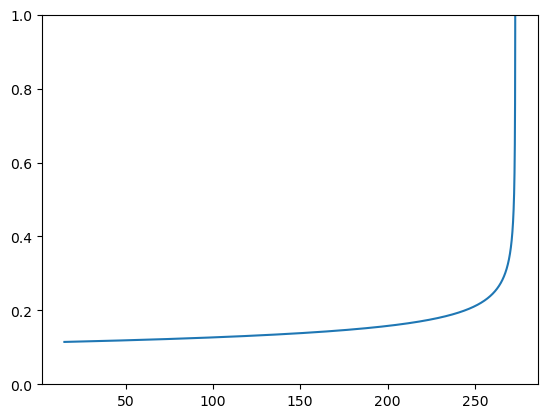

In [166]:
t_test = np.arange(15,273.15,0.01)
plt.plot(t_test, (Tf/(273.15-t_test))**beta)
plt.ylim(0,1)

In [175]:
### Numerical Model ###
from line_profiler import LineProfiler

# Create a LineProfiler object
profiler = LineProfiler()
@profiler
def model_run():
    start_time = time.time()

    col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
    for col in col_incl:
        if col==1:            ### Defining the column in use
            runtime=500      # Simulation runtime
            materialid=np.copy(Z0_1MatID)
        elif col==2:            ### Defining the column in use
            runtime=500      # Simulation runtime
            materialid=np.copy(Z1_2MatID)

        material_properties = {1: (nL, p_soilL, cp_soilL, k_soilL),\
                               2: (nL, p_rock, cp_rock, k_rock),\
                               3: (nI, p_ice, cp_ice, k_ice)}

        for ii in range(nocell):
            if materialid[ii] in material_properties:
                n_grid[ii], p_soil[ii], cp_soil[ii], k_soil[ii] = material_properties[materialid[ii]]
            else:
                print('error')

        no_tstep = int(runtime / tstep)  # Total number of time steps, DIFFERENT FOR EACH ZONE

        T_11 = np.copy(T_ann10q[:no_tstep + 1])  # Cutting temperature curve to simulation period
        #T_1 = np.flip(T_11)  # New T_1

        ### stability criterion ###
        # calculates the effective thermal diffusivity of the soil and ice material
        # if stability < 0.5, model will proceed
        k_s_ice = ((n_grid * np.sqrt(k_ice)) + ((1-n_grid) * np.sqrt(k_soil))) ** 2
        C_s_ice = (n_grid * p_ice * cp_ice) + ((1 - n_grid) * p_soil * cp_soil)
        a_s_ice = k_s_ice / C_s_ice
        stability = (np.max(a_s_ice) * tstep / dz**2)

        #temperature array used in numerical model
        T = np.zeros((nocell, no_tstep))
        T[:, 0] = np.copy(T_ini)

        ### heat transfer loop starts
        if col==1:
            xT_ini = np.copy(T_ini)
            k = 0 #time step count
            l = 0 #year count
            for t in range(no_tstep):
                if stability > 0.5:
                    print('stability is:', stability)
                    break
                k += 1
                for i in range(1, nocell-1): #excluding top and bottom bc they have boundary conditions
                    if xT_ini[i] < 100: #sanity check 
                        print("year =", l, 'time step =', k)
                        print("cell number:", i, "temperature:", xT_ini[i])
                        print("water fraction =", f_w[i], "dfw =", df_w[i])
                        break
                    if xT_ini[i] >= 273.15:
                        f_w[i] = 1
                    else:
                        #f_w[i] = get_fw(xT_ini[i])
                        f_w[i] = calculate_fw(xT_ini[i], T_f, beta) #data from Sizemore et al. (2015)
                        #f_w[i] = np.exp(-((xT_ini[i]-273.15)/w)**2) #Hornum SFC

                    f_ice[i] = 1 - f_w[i]
                    F_w[i] = f_w[i] * n_grid[i]
                    F_ice[i] = f_ice[i] * n_grid[i]

                    if xT_ini[i] > 273.15:
                        df_w[i] = 0
                    else:
                        df_w[i] = calculate_dfw(xT_ini[i], T_f, beta) #Sizemore et al. (2015)
                        #df_w[i] = get_dfw(xT_ini[i])
                        #df_w[i] = -2 * (xT_ini[i]-273.15) * np.exp(-((xT_ini[i]-273.15) / w) ** 2) #Hornum SFC

                    #calculating equivalent material properties
                    k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (F_w[i] * np.sqrt(k_w)) + (F_ice[i] * np.sqrt(k_ice))) ** 2
                    C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (F_w[i] * p_w * cp_w) + (F_ice[i] * p_ice * (cp_ice + L * df_w[i]))
                    a_eq[i] = k_eq[i] / C_eq[i]

                    #if (xT_ini[i + 1] - xT_ini[i - 1]) != 0:
                    T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
                    #else:
                     #   T[i, t] = xT_ini[i]

                    T[0, t] = T_11[k + (l*20)] #setting the top temp to B.C. from csv file
                    T[nocell - 1, t] = T[nocell - 2, t] + (dz * T_gradient) # constant flux BC

                xT_ini = np.copy(T[:, t])    ### Value used in loop

                a_eq_0_1=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
                C_eq_0_1=np.copy(C_eq)
                f_w_0_1=np.copy(f_w)
                f_ice_0_1=np.copy(f_ice)

                 ### Creating a matrix with the temperature distribution for each year
                if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
                    if l != runtime:
                        ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                        # updates column of T matrix w temps from time step at the end of each year
                        T_matx_0_1[:,l]=np.copy(T[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                        f_matx_0_1[:,l]=np.copy(f_w)
                        l+=1 # INCREASE TO NEXT YEAR
                        k=0
                    elif l == runtime:
                        l += 1
                        k = 0

    #    elif col==2:
    #        xT_ini = np.copy(T_ini)
    #        k = 0 #time step count
    #        l = 0 #year count
    #        for t in range(no_tstep):
    #            if stability > 0.5:
    #                break
    #            k += 1
    #            for i in range(1, nocell-1): #excluding top and bottom bc they have prescribed fractions
    #                f_w[i] = get_fw(xT_ini[i])
    #                f_ice[i] = 1 - f_w[i]

                    # df_w/dT
                    #not sure how to handle this next block of code with new freezing curve
    #                if xT_ini[i] < 271.15:
    #                    df_w[i] = 0
    #                elif xT_ini[i] > 273.15:
    #                    df_w[i] = 0
    #                else:
    #                    df_w[i] = -2 * xT_ini[i] * np.exp(-(xT_ini[i] / w) ** 2)  # diff of eq. A — leave this for now

    #                F_w[i] = f_w[i] * n_grid[i]
    #                F_ice[i] = f_ice[i] * n_grid[i]

                    #calculating equivalent material properties
    #                k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (f_w[i] * np.sqrt(k_w)) + (f_ice[i] * np.sqrt(k_ice))) ** 2
    #                C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (f_w[i] * p_w * cp_w) + (f_ice[i] * p_ice * (cp_ice + L * df_w[i]))
    #                a_eq[i] = k_eq[i] / C_eq[i]

    #                if (xT_ini2[i + 1] - xT_ini2[i - 1]) != 0:
    #                    T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
    #                else:
    #                    T[i, t] = xT_ini[i]

    #                T[0, t] = T_1[t] #setting the top boundary to 150 K
    #                T[nocell - 1, t] = T[nocell - 2, t] + dz * T_gradient #this can be changed to whatever we want the bottom boundary to be

    #            xT_ini = np.copy(T[:, t])      ### Value used in loop

    #            a_eq_1_2=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
    #            C_eq_1_2=np.copy(C_eq)
    #            f_w_1_2=np.copy(f_w)
    #            f_ice_1_2=np.copy(f_ice)

                 ### Creating a matrix with the temperature distribution for each year
    #            if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
    #                if l != runtime:
                        ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                        # updates column of T matrix w temps from time step
    #                    T_matx_1_2[:,l]=np.copy(T[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
    #                    f_matx_1_2[:,l]=np.copy(f_w)
    #                    l+=1 # INCREASE TO NEXT YEAR
    #                    k=0
    #                elif l == runtime:
    #                    l += 1
    #                    k = 0



    print('complete')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

In [178]:
model_run()

KeyboardInterrupt: 

In [179]:
print(T_matx_0_1[:, 200])

[223.6437     273.14982398 273.1498576  273.14998469 273.14999835
 273.14999982 273.14999998 273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15       273.15       273.15
 273.15       273.15       273.15 

In [43]:
profiler.print_stats()

Timer unit: 1e-09 s

Total time: 58.9974 s
File: /var/folders/q6/f8_x77hj45d1kngmhhrc3k9r0000gn/T/ipykernel_696/2838956120.py
Function: model_run at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @profiler
     7                                           def model_run():
     8         1       4000.0   4000.0      0.0      start_time = time.time()
     9                                           
    10         1          0.0      0.0      0.0      col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
    11         2       2000.0   1000.0      0.0      for col in col_incl:
    12         1       1000.0   1000.0      0.0          if col==1:            ### Defining the column in use
    13         1       1000.0   1000.0      0.0              runtime=500      # Simulation runtime
    14    

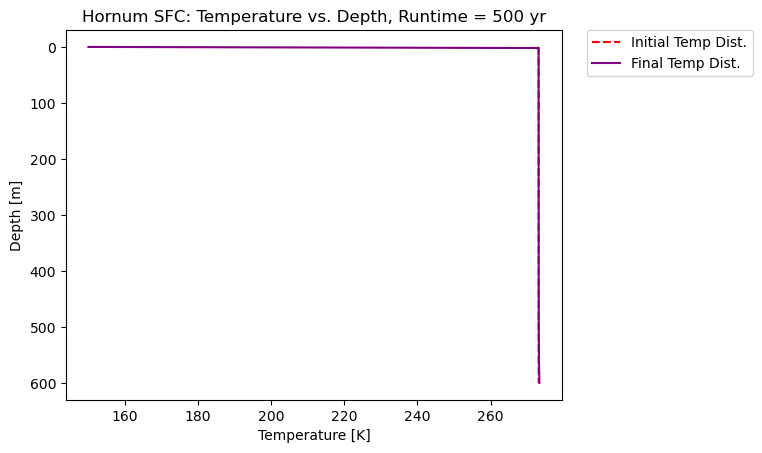

In [180]:
### Fig - Final temperature distrubution
#plotting curves for initial and final temp distributions

plt.figure()
#plt.xlim([100,400])
#plt.ylim(-.1,40)
plt.plot(T_matx_0_1[:,0], z, linestyle='dashed',color='red', label='Initial Temp Dist.')
#plt.plot(T_matx_0_1[:,1000], z, color='orange', label='1000 yr')
#plt.plot(T_matx_0_1[:,5000], z, color='yellow', label='5000 yr')
#plt.plot(T_matx_0_1[:,4000], z, color='green', label='4000 yr')
#plt.plot(T_matx_0_1[:,4500], z, color='blue', label='4500 yr')
plt.plot(T_matx_0_1[:,runtime-1], z, color='purple', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title('Hornum SFC: Temperature vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [22]:
# comparing to Hornum's use of freezing curve
start_time = time.time()

T_matx_HORNUM=np.zeros((nocell,runtime)) ### CREATING EMPTY TEMP MATRICES FOR EACH ZONE'S RUN TIME (100000 yr)
T_matx_HORNUM[:,0] = np.copy(T_ini) 
f_matx_HORNUM=np.zeros((nocell,runtime)) #water fraction
f_matx_HORNUM[:,0] = np.copy(f_ice)

col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
for col in col_incl:
    if col==1:            ### Defining the column in use
        runtime=500      # Simulation runtime
        materialid=np.copy(Z0_1MatID)
    elif col==2:            ### Defining the column in use
        runtime=500      # Simulation runtime
        materialid=np.copy(Z1_2MatID)

    material_properties = {1: (nL, p_soilL, cp_soilL, k_soilL),\
                           2: (nL, p_rock, cp_rock, k_rock),\
                           3: (nI, p_ice, cp_ice, k_ice)}

    for ii in range(nocell):
        if materialid[ii] in material_properties:
            n_grid[ii], p_soil[ii], cp_soil[ii], k_soil[ii] = material_properties[materialid[ii]]
        else:
            print('error')

    no_tstep = int(runtime / tstep)  # Total number of time steps, DIFFERENT FOR EACH ZONE

    T_11 = np.copy(T_ann10q[:no_tstep + 1])  # Cutting temperature curve to simulation period
    #T_1 = np.flip(T_11)  # New T_1

    ### stability criterion ###
    # calculates the effective thermal diffusivity of the soil and ice material
    # if stability < 0.5, model will proceed
    k_s_ice = ((n_grid * np.sqrt(k_ice)) + ((1-n_grid) * np.sqrt(k_soil))) ** 2
    C_s_ice = (n_grid * p_ice * cp_ice) + ((1 - n_grid) * p_soil * cp_soil)
    a_s_ice = k_s_ice / C_s_ice
    stability = (np.max(a_s_ice) * tstep / dz**2)

    #temperature array used in numerical model
    T_HORNUM = np.zeros((nocell, no_tstep))
    T_HORNUM[:, 0] = np.copy(T_ini)

    ### heat transfer loop starts
    if col==1:
        xT_ini = np.copy(T_ini)
        k = 0 #time step count
        l = 0 #year count
        for t in range(no_tstep):
            if stability > 0.5:
                print('stability = ', stability)
                break
            k += 1
            for i in range(1, nocell-1): #excluding top and bottom bc they have boundary conditions
                #xT_ini[i] = round(xT_ini[i], 5)
                if xT_ini[i] < 100: #sanity check 
                    print(xT_ini)
                    break
                if xT_ini[i] >= 273.15:
                    f_w[i] = 1
                #elif xT_ini[i] <= 204: #below this temp, SFC_fw goes to 0
                #    f_w[i] = 0
                else:
                    #print(xT_ini[i])
                    f_w[i] = np.exp(-((xT_ini[i]-273.15)/0.957725)**2)

                f_ice[i] = 1 - f_w[i]
                F_w[i] = f_w[i] * n_grid[i]
                F_ice[i] = f_ice[i] * n_grid[i]

                if xT_ini[i] > 273.15:
                    df_w[i] = 0
                #elif xT_ini[i] <= 204: #below this temp, SFC_fw goes to 0
                #    df_w[i] = 0
                else:
                    df_w[i] = -2 * (xT_ini[i]-273.15) * np.exp((-((xT_ini[i]-273.15) / 0.957725)) ** 2) / 0.957725
                    #df_w[i] = get_dfw(xT_ini[i])

                #calculating equivalent material properties
                k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (F_w[i] * np.sqrt(k_w)) + (F_ice[i] * np.sqrt(k_ice))) ** 2
                C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (F_w[i] * p_w * cp_w) + (F_ice[i] * p_ice * (cp_ice + L * df_w[i]))
                a_eq[i] = k_eq[i] / C_eq[i]

                if (xT_ini[i + 1] - xT_ini[i - 1]) != 0:
                    T_HORNUM[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
                else:
                    T_HORNUM[i, t] = xT_ini[i]

                T_HORNUM[0, t] = T_11[k + (l*20)] #setting the top temp to B.C. from csv file
                T_HORNUM[nocell - 1, t] = T_HORNUM[nocell - 2, t] + (dz * T_gradient) # constant flux BC

            xT_ini = np.copy(T_HORNUM[:, t])    ### Value used in loop

            a_eq_0_1=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
            C_eq_0_1=np.copy(C_eq)
            f_w_0_1=np.copy(f_w)
            f_ice_0_1=np.copy(f_ice)

             ### Creating a matrix with the temperature distribution for each year
            if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
                if l != runtime:
                    ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                    # updates column of T matrix w temps from time step at the end of each year
                    T_matx_HORNUM[:,l]=np.copy(T_HORNUM[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                    f_matx_HORNUM[:,l]=np.copy(f_w)
                    l+=1 # INCREASE TO NEXT YEAR
                    k=0
                elif l == runtime:
                    l += 1
                    k = 0
print('complete')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

complete
Elapsed time: 38.095542907714844 seconds


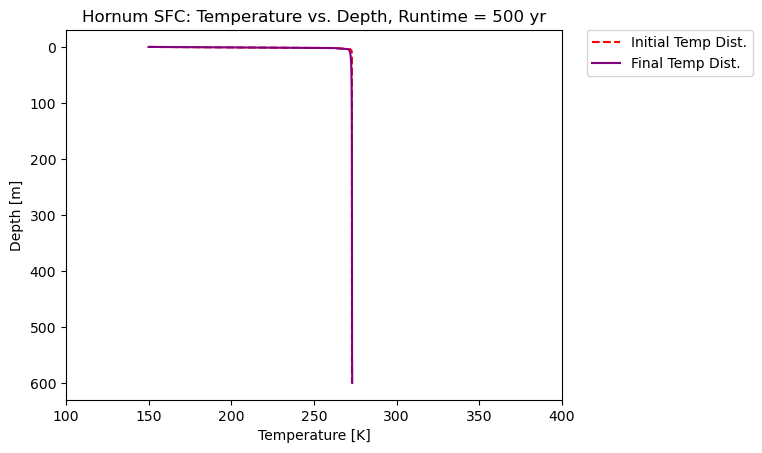

In [24]:
#Hornum case

plt.figure()
plt.xlim([100,400])
#plt.ylim(-.1,40)
plt.plot(T_matx_HORNUM[:,0], z, linestyle='dashed',color='red', label='Initial Temp Dist.')
#plt.plot(T_matx_HORNUM[:,1000], z, color='orange', label='1000 yr')
#plt.plot(T_matx_HORNUM[:,5000], z, color='yellow', label='5000 yr')
#plt.plot(T_matx_HORNUM[:,10000], z, color='green', label='10000 yr')
#plt.plot(T_matx_HORNUM[:,7999], z, color='blue', label='8000 yr')
plt.plot(T_matx_HORNUM[:,runtime-1], z, color='purple', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title('Hornum SFC: Temperature vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
#PLOTTING THE DIFFERENCE IN TEMP BW HORNUM CASE AND OUR CASE

delta_t = np.zeros((nocell, runtime))
for t in range(runtime):
    for k in range(nocell):
        delta_t[k,t] = T_matx_0_1[k,t] - T_matx_HORNUM[k,t]

In [ ]:
# delta T plot

plt.figure()
#plt.xlim([100,400])
#plt.ylim(-.1,40)
plt.plot(delta_t[:,0], z, linestyle='dashed',color='red', label='Initial Temp Dist.')
plt.plot(delta_t[:,1000], z, color='orange', label='1000 yr')
plt.plot(delta_t[:,5000], z, color='yellow', label='5000 yr')
plt.plot(delta_t[:,10000], z, color='green', label='10000 yr')
#plt.plot(delta_t[:,7999], z, color='blue', label='8000 yr')
plt.plot(delta_t[:,runtime-1], z, color='purple', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature Difference [K]')
plt.ylabel('Depth [m]')
plt.title('Temperature Difference vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

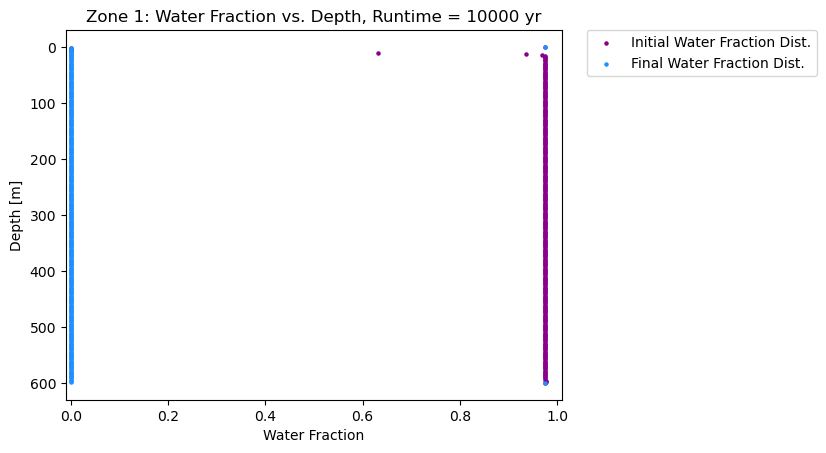

In [103]:
### Fig - Final ice fraction distrubution
#plotting curves for initial and final f_ice distributions

plt.figure()
plt.xlim([-0.01,1.01])
plt.scatter(f_matx_0_1[:,0], z, color='darkmagenta', label='Initial Water Fraction Dist.', s=5)
#plt.scatter(f_matx_0_1[:,1000], z, color='pink', label='1000 yr', s=5)
#plt.scatter(f_matx_0_1[:,5000], z, color='green', label='5000 yr', s=5)
#plt.scatter(f_matx_0_1[:,10000], z, color='red', label='10000 yr', s=5)
#plt.plot(f_matx_0_1[:,8000], z, color='teal', label='8000 yr')
plt.scatter(f_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Water Fraction Dist.', s=5)
plt.gca().invert_yaxis()
plt.xlabel('Water Fraction')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Water Fraction vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
### Fig - Final ice fraction distrubution
#plotting curves for initial and final f_ice distributions

plt.figure()
plt.xlim([-0.01,1.01])
plt.scatter(f_matx_HORNUM[:,0], z, color='darkmagenta', label='Initial Water Fraction Dist.', s=5)
plt.scatter(f_matx_HORNUM[:,1000], z, color='pink', label='1000 yr', s=5)
plt.scatter(f_matx_HORNUM[:,5000], z, color='green', label='5000 yr', s=5)#plt.scatter(f_matx_0_1[:,10000], z, color='red', label='10000 yr', s=5)
plt.plot(f_matx_HORNUM[:,10000], z, color='teal', label='8000 yr')
plt.scatter(f_matx_HORNUM[:,runtime-1], z, color='dodgerblue', label='Final Water Fraction Dist.', s=5)
plt.gca().invert_yaxis()
plt.xlabel('Water Fraction')
plt.ylabel('Depth [m]')
plt.title('Hornum SFC: Water Fraction vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
# when runtime is 100,000 yr, code takes ~2 hr to run

## Aggradation rate and depth of PF & FF

In [124]:
TqFF= 271.15 #K, freezing front temp
Tq_1= 272.15 #not sure what this is
TqPF= 273.15 #permafrost temp
t_intv=1         ### Time interval between columns in T_matx [yr]
nocell_1=nocell-1

Dcol0=0 #not sure what these are 
Dcol1=615
Dcol2=1965
Dcol3=3375
Dcol4=4505
Dcol5=5220
Dcol6=5670
Dcol7=6020
Dcol8=6570
Dcol9=7337.5
Dcol10=8712.5
Dcol11=12305
Dcol12=15000
DcolFar=18000    ### value not used


presentFFdepth = np.empty(nocell)
presentPFdepth = np.empty(nocell)
presentAggrRate = np.empty(nocell)
DtoDF = np.empty(nocell)

presentFFdepth[0]=0
presentPFdepth[0]=0
presentAggrRate[0]=0
DtoDF[0]=0

temp = np.zeros((nocell,runtime))

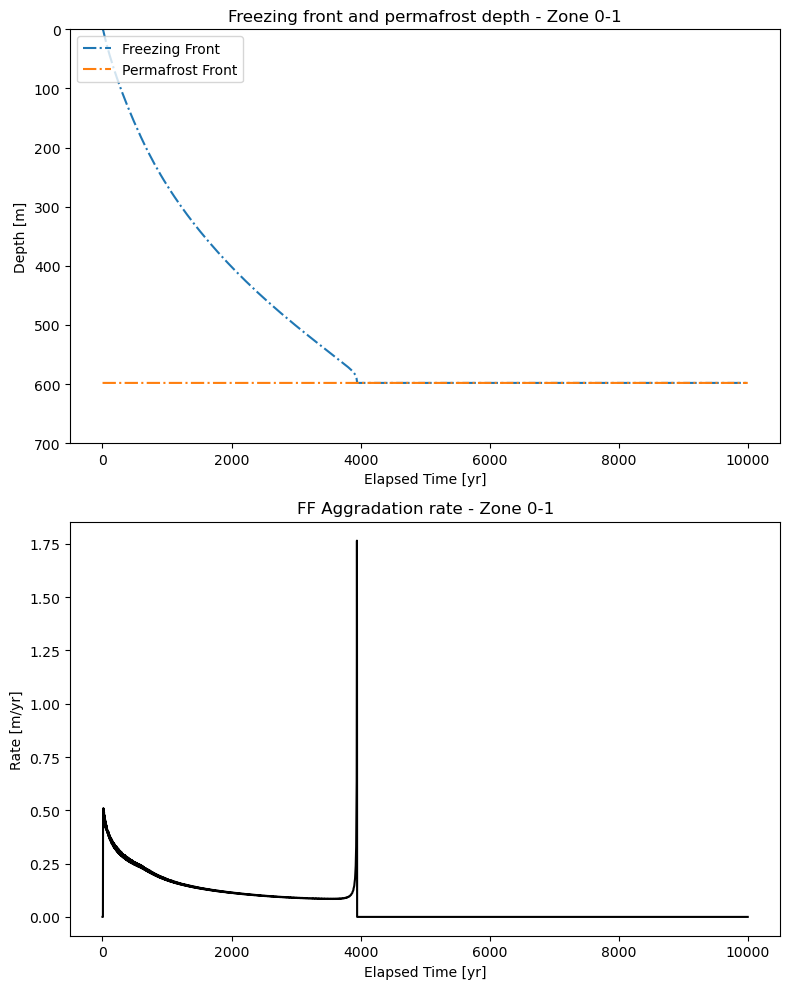

In [125]:
colcount = [1]

for col in colcount:
    if col==1:
        l = runtime  # Runtime [yr]
        k = 0
        zqFF = np.zeros(l)
        zq_1 = np.zeros(l)
        zqPF = np.zeros(l)
        temp = np.zeros((nocell, l))
        tt = np.arange(1, l + 1, t_intv)
        tt_shift = np.arange(1, l, t_intv)
        aggr_rateFF = np.zeros(l-1)
        aggr_rate_1 = np.zeros(l-1)
        aggr_ratePF = np.zeros(l-1)

        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx

            transposed_temp = np.transpose(temp[0:nocell_1, k-1]) # Switches rows and columns
            interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')
            
            if TqFF < np.min(transposed_temp) or TqFF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqFF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqFF)

            zqFF[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if Tq_1 < np.min(transposed_temp) or Tq_1 > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(Tq_1, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(Tq_1)


            zq_1[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if TqPF < np.min(transposed_temp) or TqPF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqPF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqPF)

            zqPF[i] = interpolated_value
            tt[i] = t_intv * k

        colcount[0] += 1
        presentFFdepth[colcount[0]]=zqFF[len(zqFF)-1]
        presentPFdepth[colcount[0]]=zqPF[len(zqPF)-1]
        DtoDF[colcount]=Dcol1

        no_points = len(zqFF)
        tt_shifted = tt - 0.5 * t_intv
        tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
        tt_shift_BP = np.flip(tt_shift)
        tt_flip = np.flip(tt)

        for ii in range(len(zqFF)-1):
            aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

        presentAggrRate[colcount]=aggr_rateFF[len(aggr_rateFF)-1]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the Freezing front and PF depth data in the first subplot
axes[0].plot(tt, zqFF, '-.', label='Freezing Front')
axes[0].plot(tt, zqPF, '-.', label='Permafrost Front')
axes[0].set_title('Freezing front and permafrost depth - Zone 0-1')
axes[0].invert_yaxis()
axes[0].set_xlabel('Elapsed Time [yr]')
axes[0].set_ylabel('Depth [m]')
axes[0].legend(loc='upper left')
axes[0].set_ylim(grid_depth+100, 0)

# Plot the Aggradation rate data in the second subplot
axes[1].plot(tt_shift, aggr_rateFF, 'k')
axes[1].set_title('FF Aggradation rate - Zone 0-1')
axes[1].set_xlabel('Elapsed Time [yr]')
axes[1].set_ylabel('Rate [m/yr]')
#axes[1].legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
#Hornum case

colcount = [1]

for col in colcount:
    if col==1:
        l = runtime  # Runtime [yr]
        k = 0
        zqFF = np.zeros(l)
        zq_1 = np.zeros(l)
        zqPF = np.zeros(l)
        temp = np.zeros((nocell, l))
        tt = np.arange(1, l + 1, t_intv)
        tt_shift = np.arange(1, l, t_intv)
        aggr_rateFF = np.zeros(l-1)
        aggr_rate_1 = np.zeros(l-1)
        aggr_ratePF = np.zeros(l-1)

        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_HORNUM[0:nocell, k-1]  # Use the appropriate T_matx

            transposed_temp = np.transpose(temp[0:nocell_1, k-1]) # Switches rows and columns
            interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')
            
            if TqFF < np.min(transposed_temp) or TqFF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqFF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqFF)

            zqFF[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_HORNUM[0:nocell, k-1]  # Use the appropriate T_matx
            
            if Tq_1 < np.min(transposed_temp) or Tq_1 > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(Tq_1, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(Tq_1)


            zq_1[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_HORNUM[0:nocell, k-1]  # Use the appropriate T_matx
            
            if TqPF < np.min(transposed_temp) or TqPF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqPF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqPF)

            zqPF[i] = interpolated_value
            tt[i] = t_intv * k

        colcount[0] += 1
        presentFFdepth[colcount[0]]=zqFF[len(zqFF)-1]
        presentPFdepth[colcount[0]]=zqPF[len(zqPF)-1]
        DtoDF[colcount]=Dcol1

        no_points = len(zqFF)
        tt_shifted = tt - 0.5 * t_intv
        tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
        tt_shift_BP = np.flip(tt_shift)
        tt_flip = np.flip(tt)

        for ii in range(len(zqFF)-1):
            aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

        presentAggrRate[colcount]=aggr_rateFF[len(aggr_rateFF)-1]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the Freezing front and PF depth data in the first subplot
axes[0].plot(tt, zqFF, '-.', label='Freezing Front')
axes[0].plot(tt, zqPF, '-.', label='Permafrost Front')
axes[0].set_title('Freezing front and permafrost depth - Zone 0-1')
axes[0].invert_yaxis()
axes[0].set_xlabel('Elapsed Time [yr]')
axes[0].set_ylabel('Depth [m]')
axes[0].legend(loc='upper left')
axes[0].set_ylim(grid_depth+100, 0)

# Plot the Aggradation rate data in the second subplot
axes[1].plot(tt_shift, aggr_rateFF, 'k')
axes[1].set_title('FF Aggradation rate - Zone 0-1')
axes[1].set_xlabel('Elapsed Time [yr]')
axes[1].set_ylabel('Rate [m/yr]')
#axes[1].legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
print(zqFF)

In [ ]:
print(zqPF)

## Final PF and FF depths

In [ ]:
plt.plot(DtoDF, presentFFdepth, c='blue', label='Final FF Depth')
plt.plot(DtoDF, presentPFdepth, c='red', label='Final PF Depth')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Depth [m]')
plt.title('Permafrost and freezing front depths')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

## Final Aggradation Rate and Recharge Equivalent

In [ ]:
plt.plot(DtoDF[2:], presentAggrRate[2:], c='blue')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Rate [m/yr]')
plt.title('Aggradation rate and recharge equivalent')

In [ ]:
# next steps: add in temp-dependent material properties? play with diff layers? Investigate FF and PF depths 

## Plotting Final Effective Material Properties 

In [ ]:
print(a_eq_0_1)

In [ ]:
print(C_eq_0_1)

In [ ]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective thermal diffusivity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(a_eq_0_1, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
#plt.plot(a_eq_1_2, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Thermal Diffusivity [m^2/s]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Thermal Diffusivity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [ ]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective heat capacity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(C_eq_0_1/1e6, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
plt.plot(C_eq_1_2/1e6, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Heat Capacity [MJ/K]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Heat Capacity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [ ]:
np.shape(a_eq_0_1)